# Implementing MDS in the Poincaré Disk
`Drew Wilimitis`

My approach will primarily follow the general algorithmic outline discussed by A. Cvetkovski and M. Crovellain in **[1]**. As far as I am aware there aren't any released implementations of this Poincaré Disk MDS algorithm, although there was a very recent release of a PyTorch implementation of Hyperbolic MDS that seems to use a modified Principal Component Analysis as well as the hyperboloid model of hyperbolic space, which is discussed in **[3]**. <br>
<br>
I implement this hyperbolic MDS algorithm with Numpy and try to base some general aspects of the implementation structure on the design of Multidimensional Scaling from the `sklearn.manifold` library. In the final section I test my hMDS model on some sample datasets and compare the results to those provided in **[1]**.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from sklearn.metrics import euclidean_distances
import time
import sys
import os

# import modules within repository
#from utils import *
from hmds import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Evaluating Hyperbolic MDS Results <br>

After first defining some functions to visualize training and evaluation results, we then apply Hyperbolic MDS to three different relatively simple test cases.

In [4]:
# run several rounds of hMDS and plot results
def plot_errors(model, input_data, title = 'Embedding Errors', num_rounds = 20):
    results = []
    for i in range(num_rounds):
        embed = model.fit_transform(input_data)
        stress = sammon_stress(embed, model.dissimilarity_matrix)
        results.append(stress)
    plt.figure(figsize=(7,5))
    plt.scatter(x=np.arange(0, len(results), 1), y=np.sort(results))
    plt.ylabel('Stress')
    plt.xlabel('hMDS Ranks')
    plt.title(title)
    plt.show()
    print('Min Error: ', np.min(results))
    print('Mean Error: ', np.mean(results))
    print('Std. Deviation of Error: ', np.std(results))
    
# plot scaling factor and stress values
def plot_alpha(model, input_data, title = 'Hyperbolic Scale Factor'):
    results = []
    alpha_range = np.arange(0.5, 10, 0.5)
    for alpha in alpha_range:
        model = HyperMDS(alpha = alpha)
        embed = model.fit_transform(input_data)
        stress = sammon_stress(embed, model.dissimilarity_matrix, alpha=alpha)
        results.append(stress)
    plt.figure(figsize=(7,5))
    plt.scatter(x=alpha_range, y=results)
    plt.ylabel('Stress')
    plt.xlabel('Scale factor alpha')
    plt.title(title)
    plt.show();

# plot metrics for each iteration of hMDS training
def plot_training_metrics(input_data, title = 'Metrics at Each Iteration'):
    model = HyperMDS(save_metrics = True)
    embed = model.fit_transform(input_data, max_epochs=20)
    fig = plt.figure(constrained_layout=True, figsize=(20, 15))
    spec = plt.GridSpec(ncols=2, nrows=2, figure=fig)
    n = len(model.losses)
    metrics = [model.losses, model.gradient_norms, model.steps, model.rel_steps]
    names = ['Error', 'Gradient Norm', 'Step Size', 'Rel. Step Size (r/rmax)']
    for i in range(4):
        ax = fig.add_subplot(spec[i])
        ax.scatter(np.arange(0, n, 1), metrics[i], s=60)
        ax.set_title(names[i], size=32)
        ax.tick_params(axis='both', which='major', labelsize=26)
    plt.suptitle(title, size=46)

### Ex 1.) Seven point sample

The first dataset used to test this implementation of Hyperbolic MDS is a simple random sample of seven data points in the poincaré disk, and we use the hyperbolic distances as our input dissimilarities to hMDS. Starting from a different random embedding configuration, hMDS is able to fit a very low stress embedding and recover the input similarities.

In [5]:
data = generate_data(7)
hmds = HyperMDS(dissimilarity='hyperbolic', alpha=1)
emb = hmds.fit_transform(data, max_epochs=30)
print('Sammon Stress: ', sammon_stress(emb, hmds.dissimilarity_matrix, alpha=1))

Sammon Stress:  4.334715894409418e-05


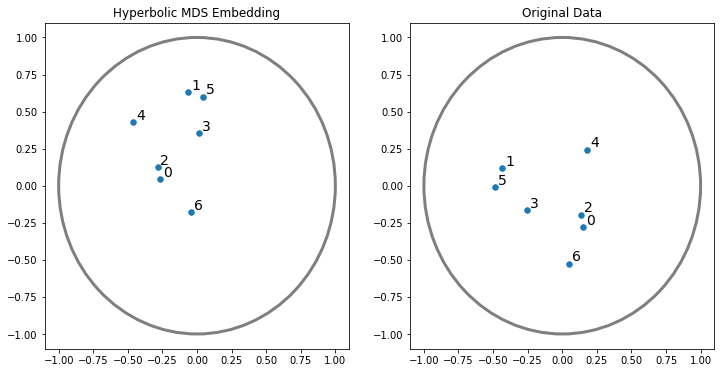

In [11]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = emb[:,0]
y = emb[:,1]
ax.scatter(x, y, s=30, alpha=1)
for i in range(len(emb)):
    ax.text(x[i]+0.02, y[i]+0.02, str(i), size=14)
ax.set_title('Hyperbolic MDS Embedding')
    
ax2 = fig.add_subplot(122)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax2.add_patch(circ)

x = data[:,0]
y = data[:,1]
ax2.scatter(x, y, s=30, alpha=1)
for i in range(len(data)):
    ax2.text(x[i]+0.02, y[i]+0.02, str(i), size=14);
ax2.set_title('Original Data')
plt.show();

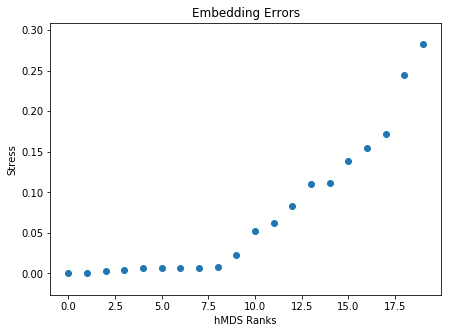

Min Error:  5.46502598813253e-08
Mean Error:  0.0738798546061011
Std. Deviation of Error:  0.08439775654400873


In [12]:
data = generate_data(7)
hmds = HyperMDS(dissimilarity='hyperbolic', alpha=1)
plot_errors(hmds, data)

Since it's possible to converge to local stationary points and local minimums with our gradient descent method, running hMDS with multiple different initial configurations gives a better idea of the global minimum, shown here with some outliers with worse performance.

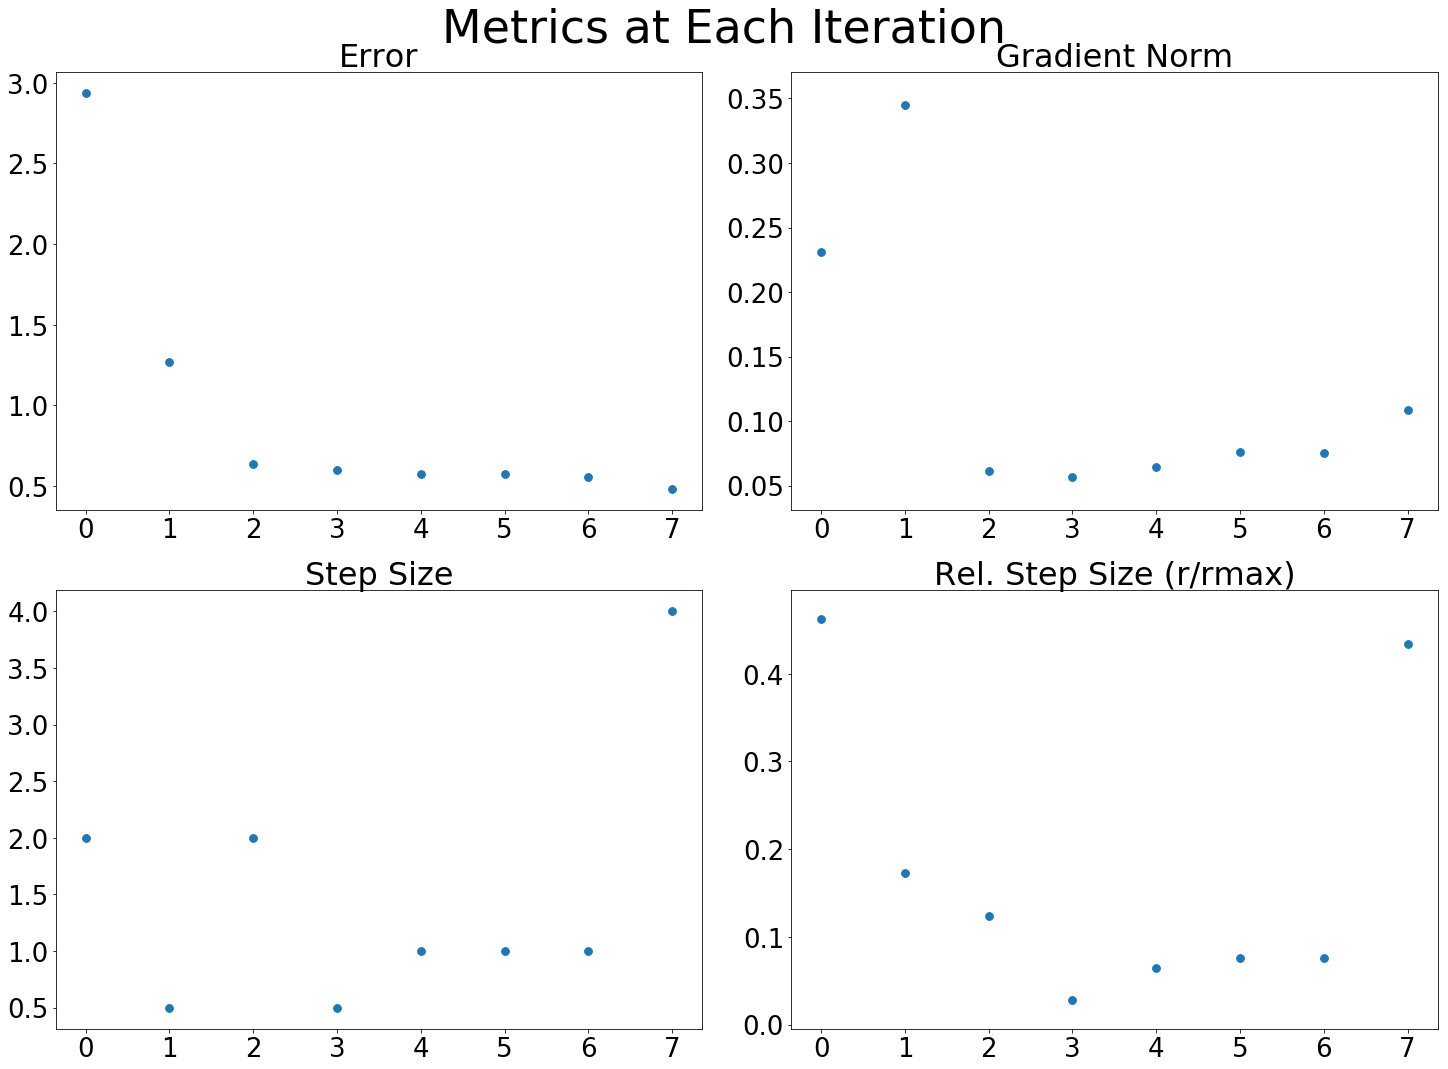

In [13]:
plot_training_metrics(data)

### Ex 2.) Animals Dataset

The next test case is a subset of the animals dataset is from UCI ML repository https://archive.ics.uci.edu/ml/datasets/zoo. It contains 17 features indicating various animal attributes. Ideally the hyperbolic distances of the embedding reflect the qualitative similarities of the animal classes. The input dissimilarity is the euclidean distances between observations in the dataset.  

In [14]:
zoo = pd.read_csv('../data/zoo.data', header=None)
animals = ['hare', 'goat', 'octopus', 'wolf', 'chicken', 'tuna', 'lobster', 'cheetah', 
           'dove', 'opossum', 'raccoon', 'crow', 'sparrow']
animals_data = zoo.loc[zoo[0].apply(lambda x: x in animals), ]
animals_name = animals_data[0]
animals_data = animals_data.loc[:, 1:]
animals_name = np.array(animals_name)
zoo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


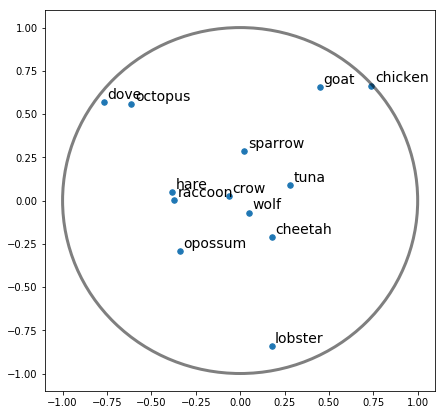

In [15]:
hmds = HyperMDS()
animals_emb = hmds.fit_transform(animals_data, max_epochs=20)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = animals_emb[:,0]
y = animals_emb[:,1]
ax.scatter(x, y, s=30, alpha=1)
for i in range(len(animals_emb[:40])):
    ax.text(x[i]+0.02, y[i]+0.02, animals_name[i], size=14)
plt.show();

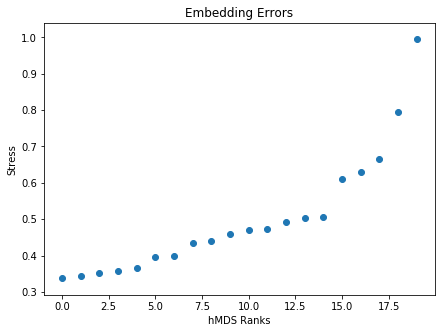

Min Error:  0.3371489407445917
Mean Error:  0.5013512686522003
Std. Deviation of Error:  0.1631084372245961


In [16]:
data = animals_data
hmds = HyperMDS()
plot_errors(hmds, data)

### Ex 3.) Iris Data

Finally, we apply hyperbolic MDS to the iris data with input dissimilarity matrix as the euclidean distances between the 150 iris data observations that have numerical features. With three distinct classes in the iris data, we can evaluate whether hyperbolic MDS clusters similar classes together.

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = iris.data
hmds = HyperMDS(alpha=2)
iris_emb = hmds.fit_transform(iris_data)
print('Sammon Stress: ', sammon_stress(iris_emb, hmds.dissimilarity_matrix, alpha=2))

Sammon Stress:  0.7113061614259998


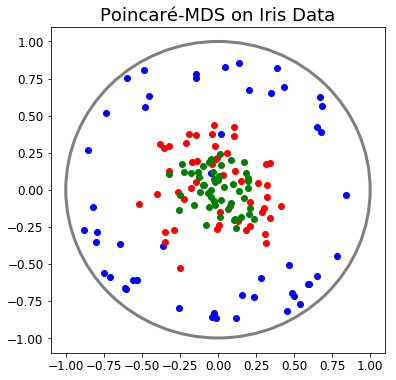

In [18]:
y = iris.target
X = iris_emb
mds_iris = pd.DataFrame(X)
mds_iris['label'] = y
mds_iris.to_csv('../data/mds_iris.csv', index=False)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
ax.scatter(X[(y==0), 0], X[(y==0), 1], c='blue')
ax.scatter(X[(y==1), 0], X[(y==1), 1], c='red')
ax.scatter(X[(y==2), 0], X[(y==2), 1], c='green')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Poincaré-MDS on Iris Data', size=18);
#plt.savefig('iris_hmds.png');

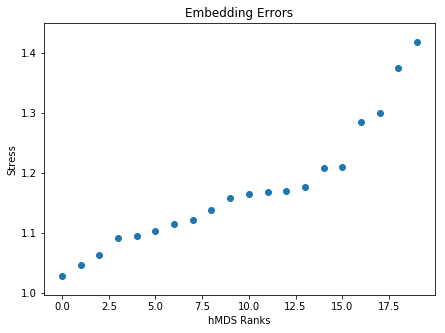

Min Error:  1.028107199409857
Mean Error:  1.1716590672399014
Std. Deviation of Error:  0.10175431258622818


In [19]:
hmds = HyperMDS()
plot_errors(hmds, iris_data, num_rounds=20)

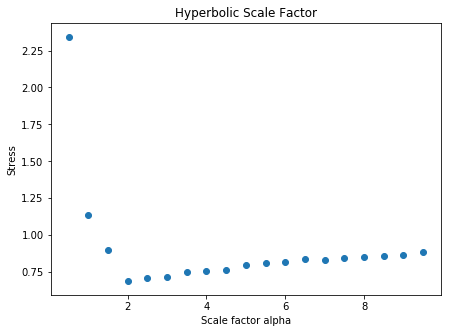

In [20]:
hmds = HyperMDS()
plot_alpha(hmds, iris_data)

## Conclusion

In comparison to the results presented in [1], the results I obtained for the simple 7 point sample was quite close to the embedding error and the general trends apparent in the training metrics. On the iris dataset, it seems I obtained a similar optimal scaling factor, but the embedding errors in [1] were significantly better, around 0.4 compared to my best result of ~0.68. There are many ways to potentially test different parameters and optimize this implementation, especially concerning optimizing the time complexity, which wasn't of significant concern to me here compared to building a basic functioning implementation. <br>
<br>
A few interesting areas to explore would be more extensive comparisons to euclidean MDS embeddings and applying hyperbolic MDS to hierarchical datasets potentially related to clustering.

In [756]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()

## Resources

**[1]**. A. Cvetkovski and M. Crovella. Multidimensional scaling in the Poincaré disk. arXiv:1105.5332, 2011.<br>
**[2]**. H-MDS: a new approach for interactive visualization with multidimensional scaling in the hyperbolic space. Jörg Walter. Information Systems, Elsevier, 29(4):273-292, 2004.<br>
**[3]** De Sa, C., Gu, A., Ré, C., and Sala, F. Representation tradeoffs for hyperbolic embeddings. arXiv preprint arXiv:1804.03329, 2018.